<a href="https://colab.research.google.com/github/isshii/de4test/blob/master/LIME/LIME_for_generated_input_from_DeepXprore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 方針
* LIME にかけるモデルを、DeepXproreで使ってるモデルに変更する
* 摂動を加えた画像を読み込んで、それぞれのモデルがどう判断しているのかを見る

In [0]:
# ドライブをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os, re
import random
import keras
# models
from keras.applications import inception_v3 as inc_net

from keras.applications import resnet50 as resnet50
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.applications import vgg16 as vgg16
from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input

from keras.applications import vgg19 as vgg19
from keras.applications.vgg19 import VGG19
# from keras.applications.vgg19 import preprocess_input

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

from keras.layers import Input

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.5


In [0]:
img_rows, img_cols = 224, 224
# img_rows, img_cols = 299, 299
input_shape = (img_rows, img_cols, 3)

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)


In [0]:
# model1 = inc_net.InceptionV3(input_tensor=input_tensor)
# model1 = VGG16(input_tensor=input_tensor)
model1 = VGG16()
# model2 = VGG19(input_tensor=input_tensor)
# model3 = ResNet50(input_tensor=input_tensor)


In [0]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
#        img = image.load_img(img_path, target_size=(299, 299))
        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
 #       x = inc_net.preprocess_input(x)
        x = vgg19.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [0]:
# DeepXproreで摂動を加えられら画像を読み込む
img_paths = list_pictures('/content/drive/My Drive/ColabNotebooks/test4ai/deepxprore_with_lime/ImageNet/generated_inputs')


## Let's see the top 5 prediction for some image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('n01855672', 'goose', 0.183068)
('n02017213', 'European_gallinule', 0.16496661)
('n01847000', 'drake', 0.148593)
('n02018207', 'American_coot', 0.09762519)
('n01855032', 'red-breasted_merganser', 0.08956369)


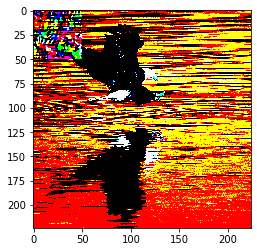

In [0]:
#for _ in range(6):
#  img = random.choice(img_paths)
#  print(img)
#  images = transform_img_fn(img)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
#  plt.imshow(images[0] / 2 + 0.5)
#  preds = inet_model.predict(images)
#  for x in decode_predictions(preds)[0]:
#      print(x)
images = transform_img_fn([os.path.join('/content/drive/My Drive/ColabNotebooks/test4ai/deepxprore_with_lime/ImageNet/generated_inputs','occl_American_coot_peacock_bald_eagle.png')])
# images = transform_img_fn([os.path.join('/content/drive/My Drive/ColabNotebooks/test4ai/deepxprore_with_lime/ImageNet/generated_inputs','occl_American_coot_peacock_bald_eagle_orig.png')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = model1.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)


## Explanation
Now let's get an explanation

In [0]:
! pip install lime
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [0]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [0]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], model1.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 23 s, sys: 2.48 s, total: 25.5 s
Wall time: 34 s


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [0]:
from skimage.segmentation import mark_boundaries

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


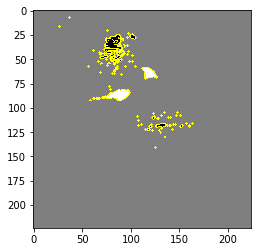

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


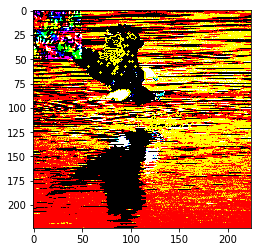

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


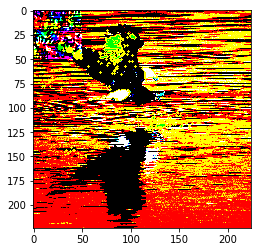

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


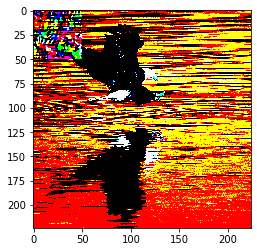

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
print(explanation.top_labels[0])

99


### Let's see the explanation for the second highest prediction

Most positive towards wombat:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


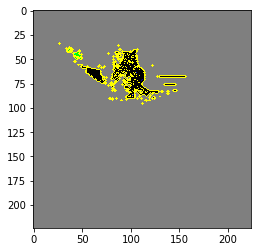

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


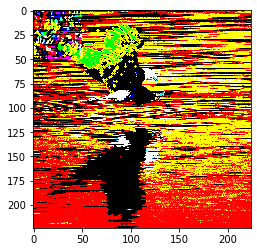

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
